
# 목표: 우리는 어떤 사람이 선거 투표에 참여하는지, 심리적 성향과 인구통계학적 정보를 가지고 예측할 수 있을까?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import xgboost as xgb
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
#데이터 불러오기
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', 100)

index = test['index']

Unneed_list = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE','QfE', 'QgE', 'QhE', 'QiE', 'QjE','QkE', 'QlE', 'QmE', 'QnE', 'QoE','QpE', 'QqE', 'QrE', 'QsE', 'QtE', 'index']

train.drop(Unneed_list, axis=1, inplace=True)
test.drop(Unneed_list, axis=1, inplace=True)

<h1>데이터 전처리</h1>

---

#### 1.데이터 확인

In [3]:
#DataFrame.isnull()을 통해 train, test 데이터에는 결손값이 없는 것을 알 수 있음.
print("train 데이터 누락값 수: {}개".format(train.isnull().sum().sum()))
print("test 데이터 누락값 수: {}개".format(test.isnull().sum().sum()))

train 데이터 누락값 수: 0개
test 데이터 누락값 수: 0개


In [4]:
test['education'].value_counts()

2    3434
3    2964
4    1554
1    1059
0      96
Name: education, dtype: int64

#### 2.결손값 처리

In [5]:
# 'education', 'engnat', 'hand', 'urban' 컬럼에 있는 무응답 0을 제거
zero_features = ['education', 'engnat', 'hand', 'married']

#결손값(무응답 = 0)제거 함수
def drop_NoResponse(df):
    for col in zero_features:
        print("{} column에서 무응답이 있는 행 {}개 삭제  ".format(col,df[df[col]==0].shape[0]))
        df.drop(df[df[col]==0].index, axis=0, inplace=True)
        
    return df

#train, test에서 결손값 제거
print('train데이터 결손값 삭제')
# train = drop_NoResponse(train)

train데이터 결손값 삭제


#### 3.이상값 처리

In [6]:
#train데이터의 "familysize"column은 2번째로 큰 값이 44이고 제일 큰 값이 999일 정도로 outlier가 존재함을 알 수 있음.
print(train['familysize'].value_counts(ascending=False))

2      14321
3       9037
1       5261
4       3917
5       1521
0        983
6        662
7        313
8        175
9        102
10        48
11        29
12        16
13        10
14         7
15         7
44         3
17         3
21         2
16         2
20         2
999        1
34         1
18         1
30         1
Name: familysize, dtype: int64


In [7]:
#IQR(Inter Quantile Range)을 이용해 이상값을 처리하는 것보단 제일 큰 값인 999만 처리하는 것이 데이터적 측면에서 훨씬 탁월하다고 생각하여 max값만 제거함.
max_index = train['familysize'].idxmax()
train.drop(max_index, axis=0, inplace=True)
train

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,1.0,5.0,5.0,1.0,1.0,1.0,5.0,5.0,2.0,5.0,2.0,5.0,4.0,1.0,5.0,4.0,1.0,1.0,5.0,5.0,20s,3,1,2,Male,1,1,White,Christian_Catholic,2,2,1,5,2,4,5,4,1,2,2,1,0,1,0,1,1,0,1,1,1,1,1,0,1,0,1,1
1,1.0,5.0,5.0,1.0,1.0,3.0,1.0,4.0,5.0,5.0,2.0,5.0,5.0,1.0,5.0,5.0,2.0,1.0,3.0,5.0,10s,2,2,4,Male,1,1,Asian,Hindu,1,0,2,2,0,6,1,5,5,6,3,1,0,0,0,1,1,1,1,1,1,1,1,0,1,0,1,1
2,5.0,1.0,2.0,1.0,3.0,5.0,4.0,3.0,5.0,3.0,5.0,1.0,1.0,5.0,1.0,1.0,2.0,5.0,1.0,4.0,20s,2,1,3,Female,1,1,White,Christian_Other,0,1,0,5,3,6,0,2,1,6,2,1,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,0
3,4.0,1.0,1.0,4.0,1.0,3.0,4.0,1.0,5.0,1.0,5.0,1.0,1.0,4.0,4.0,5.0,4.0,4.0,2.0,5.0,10s,3,2,3,Male,1,1,Other,Hindu,2,2,4,5,0,1,0,2,0,4,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
4,4.0,5.0,5.0,3.0,1.0,1.0,1.0,2.0,1.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,4.0,4.0,5.0,20s,2,1,4,Female,1,1,White,Other,6,3,6,2,0,6,2,0,6,4,2,1,0,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36420,1.0,5.0,5.0,1.0,1.0,1.0,3.0,3.0,1.0,5.0,3.0,5.0,4.0,3.0,5.0,5.0,1.0,1.0,5.0,5.0,20s,2,1,6,Female,1,1,Black,Other,4,3,3,5,0,1,2,2,0,3,2,1,0,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1
36421,3.0,4.0,5.0,2.0,1.0,3.0,1.0,3.0,4.0,5.0,4.0,2.0,5.0,2.0,4.0,5.0,3.0,2.0,5.0,5.0,10s,1,2,4,Male,3,1,White,Jewish,5,1,1,6,2,5,4,6,3,6,1,0,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1
36422,2.0,4.0,2.0,1.0,2.0,1.0,4.0,2.0,2.0,4.0,5.0,5.0,4.0,1.0,5.0,2.0,4.0,1.0,5.0,3.0,30s,4,1,6,Male,1,2,White,Agnostic,1,2,0,5,1,2,1,2,1,5,2,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1
36423,5.0,1.0,1.0,3.0,5.0,1.0,4.0,1.0,4.0,2.0,5.0,5.0,4.0,5.0,2.0,1.0,5.0,1.0,2.0,4.0,40s,4,1,4,Female,3,1,White,Other,4,4,5,4,1,3,2,5,1,5,3,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1


#### 4. 데이터 변환

In [8]:
#'gender', 'age_group', 'race', 'religion'의 데이터는 정수형이 아니기 때문에 인코딩을 통해 데이터를 정수형으로 변환
train = pd.get_dummies(train)
test = pd.get_dummies(test)

#### 5.데이터 분할

In [9]:
# train에서 label값인 'vote'를 추출하여 feature값인 train_x, label값인 train_y로 분할
train_x = train.drop('voted', axis=1)
train_y = train['voted']

X_train, X_test, y_train, y_test=train_test_split(train_x, train_y, test_size=0.2, random_state=0)


In [10]:
# def get_best_params(model, params): 
#     grid_model = GridSearchCV(model, param_grid=params, scoring=make_scorer(f1_score , average='macro'), cv=5, verbose=1) 
#     grid_model.fit(X_train, y_train) 
#     rmse = np.sqrt(-1* grid_model.best_score_) 
#     print('최적 평균 f1 값:', np.round(rmse, 4)) 
#     print('최적 파라미터:', grid_model.best_params_) 
    
#     return grid_model.best_estimator_

# param = { 
#     'max_depth' : [ 128, 160],
#     'learning_rate': [0.005, 0.01],
#     'n_estimators': [8,16,24],
#     'num_leaves': [6, 32, 64], # large num_leaves helps improve accuracy but might lead to over-fitting
#     'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
#     'min_child_samples':[50, 100]
# }



lgbm_clf = LGBMClassifier(n_estimators=400, learning_rate=0.01, max_bin=255, max_depth=128, min_child_samples=100, num_leaves=64,)

# best_estimator = get_best_params(lgbm_clf, param)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_clf.predict(X_test)


def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    
get_clf_eval(y_test, preds)

[1]	valid_0's binary_logloss: 0.68698
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.68478
[3]	valid_0's binary_logloss: 0.682622
[4]	valid_0's binary_logloss: 0.680517
[5]	valid_0's binary_logloss: 0.678449
[6]	valid_0's binary_logloss: 0.676409
[7]	valid_0's binary_logloss: 0.674423
[8]	valid_0's binary_logloss: 0.672476
[9]	valid_0's binary_logloss: 0.670574
[10]	valid_0's binary_logloss: 0.668704
[11]	valid_0's binary_logloss: 0.666863
[12]	valid_0's binary_logloss: 0.665059
[13]	valid_0's binary_logloss: 0.663279
[14]	valid_0's binary_logloss: 0.661543
[15]	valid_0's binary_logloss: 0.659834
[16]	valid_0's binary_logloss: 0.658148
[17]	valid_0's binary_logloss: 0.656501
[18]	valid_0's binary_logloss: 0.6549
[19]	valid_0's binary_logloss: 0.653321
[20]	valid_0's binary_logloss: 0.651769
[21]	valid_0's binary_logloss: 0.650238
[22]	valid_0's binary_logloss: 0.648726
[23]	valid_0's binary_logloss: 0.647244
[24]	valid_0's binary_logloss: 

[212]	valid_0's binary_logloss: 0.55909
[213]	valid_0's binary_logloss: 0.558999
[214]	valid_0's binary_logloss: 0.558908
[215]	valid_0's binary_logloss: 0.558825
[216]	valid_0's binary_logloss: 0.558732
[217]	valid_0's binary_logloss: 0.558673
[218]	valid_0's binary_logloss: 0.558587
[219]	valid_0's binary_logloss: 0.55852
[220]	valid_0's binary_logloss: 0.558438
[221]	valid_0's binary_logloss: 0.558368
[222]	valid_0's binary_logloss: 0.558277
[223]	valid_0's binary_logloss: 0.558219
[224]	valid_0's binary_logloss: 0.558142
[225]	valid_0's binary_logloss: 0.558081
[226]	valid_0's binary_logloss: 0.558
[227]	valid_0's binary_logloss: 0.557936
[228]	valid_0's binary_logloss: 0.557883
[229]	valid_0's binary_logloss: 0.557819
[230]	valid_0's binary_logloss: 0.55774
[231]	valid_0's binary_logloss: 0.557679
[232]	valid_0's binary_logloss: 0.557618
[233]	valid_0's binary_logloss: 0.557567
[234]	valid_0's binary_logloss: 0.557514
[235]	valid_0's binary_logloss: 0.557461
[236]	valid_0's binary

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

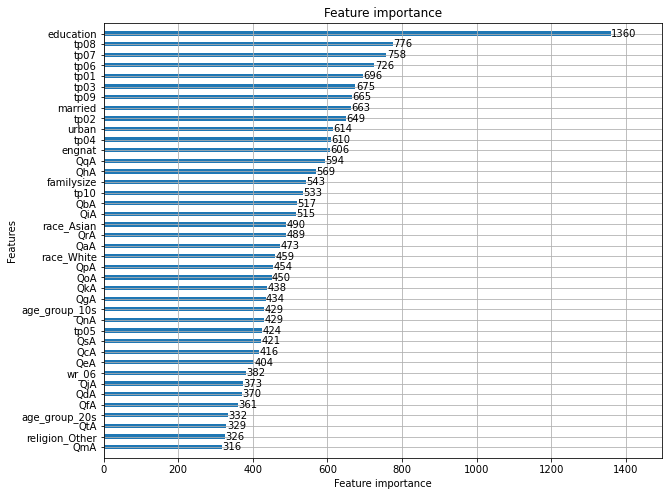

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(lgbm_clf, ax=ax, max_num_features=40, height=0.4)